# Stepping through the basic processessing of increment widths

## importing and setting up some basic things we will use

In [1]:
import pandas as pd
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import scipy.stats
pd.set_option('display.max_rows', 20)



## generate and save a sample timeseries as a text file

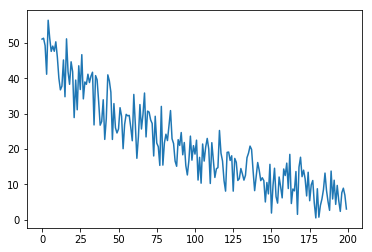

In [2]:
series1 = np.array([np.power(200-i,2) for i in range(200)])*1.0e-3
series2 = [gauss(0.0, 5.0) for i in range(200)]
series = series1 + series2
series -= np.min(series)
series += 0.5
plt.plot(series)

In [3]:
df = pd.DataFrame(series)
df.to_csv('example_shell_data.csv', float_format='%.2f', na_rep="NAN!")


## Read your data file in (as an example, I'm just re-reading in the file we just produced)

In [4]:
df = pd.read_csv('example_bivalve_increments_laura.csv')
# Note here I'm skipping the 1st row because my file had no headers, and I'm adding thee manually. You could just make sure your file matches the format of 'example_shell_data.csv or make changes to this line of code


In [5]:
my_dict = {}

for (columnName, columnData) in df.iteritems():
    my_dict[columnName] = pd.DataFrame(columns=['raw_data'])
    my_dict[columnName].raw_data = columnData
    my_dict[columnName].dropna(axis='rows',inplace=True)
    my_dict[columnName]['LogValues'] = np.log10(my_dict[columnName].raw_data)
    my_dict[columnName]['Spline'] = interpolate.UnivariateSpline(my_dict[columnName].index, my_dict[columnName]['LogValues'], k=3)(my_dict[columnName].index)
    my_dict[columnName]['Processed'] = my_dict[columnName]['LogValues'] - my_dict[columnName]['Spline']



## Saving out the data

In [6]:
df.to_csv('processed_shell_data.csv', float_format='%.2f', na_rep="NAN!")
# Note that you will want to change the name 'processed_shell_data.csv' to whatever you want to save that file as


ts8
ts6
ts7
ts4
ts5
ts2
ts3
ts1
Pearson corr:  0.487085858714 p-value:  0.0251257218565


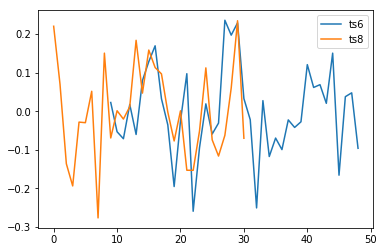

In [15]:
def sliding_correlation(x1,x2):
    window_length = 21
    length_x1 = len(x1)
    length_x2 = len(x2)
    output = np.zeros([length_x1-window_length,length_x2-window_length])
    p_out = np.zeros([length_x1-window_length,length_x2-window_length])
    if (length_x2 > window_length) & (length_x1 > window_length):
        for i in range(length_x1-window_length):
            for j in range(length_x2-window_length):
                corr_values = scipy.stats.pearsonr(x1[i:i+window_length], x2[j:j+window_length])
                cc = corr_values[0]
                p = corr_values[1]
                output[i,j] = cc
                p_out[i,j] = p
        x1_max = np.max(output[0,:])
        loc_x1_max = np.where(output[0,:] == x1_max)
        x2_max = np.max(output[:,0])
        loc_x2_max = np.where(output[:,0] == x2_max)
        if x1_max > x2_max:
            return [loc_x1_max[0][0],0],x1_max,p_out[0,loc_x1_max[0][0]]
        else:
            return [0,loc_x2_max[0][0]],x2_max,p_out[loc_x2_max[0][0],0]

    

a = 'ts6'
b = 'ts8'

shift_array1 = np.zeros([len(my_dict),len(my_dict)])
shift_array2 = np.zeros([len(my_dict),len(my_dict)])
corr_array1 = np.zeros([len(my_dict),len(my_dict)])

for i,key1 in enumerate(my_dict):
    print key1
    for j,key2 in enumerate(my_dict):
        shift,max_corr,p_value = sliding_correlation(my_dict[key1].Processed,my_dict[key2].Processed)
        shift_array1[i,j] = shift[0]
        shift_array1[i,j] = shift[1]
        corr_array1[i,j] = max_corr

shift,max_corr,p_value = sliding_correlation(my_dict[a].Processed,my_dict[b].Processed)
print 'Pearson corr: ',max_corr,'p-value: ',p_value

plt.plot(np.arange(len(my_dict[a].Processed))+shift[0],my_dict[a].Processed,label= a)
plt.plot(np.arange(len(my_dict[b].Processed))+shift[1],my_dict[b].Processed,label= b)
plt.legend()
plt.show()


## Thinking about ways to piece the whole thing together optimally

[ 0.74900135  0.63909749  0.75542053  0.76881528  0.70408744  0.6887073
  0.63630014  0.76881528]


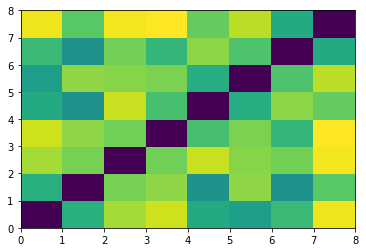

In [8]:
np.fill_diagonal(corr_array1, 0)
plt.pcolormesh(corr_array1)
max_vals = np.max(corr_array1,axis = 1)
print max_vals

max_val_locs = [np.where(corr_array1[i,:] == max_vals[i])[0][0] for i in range(len(my_dict))]

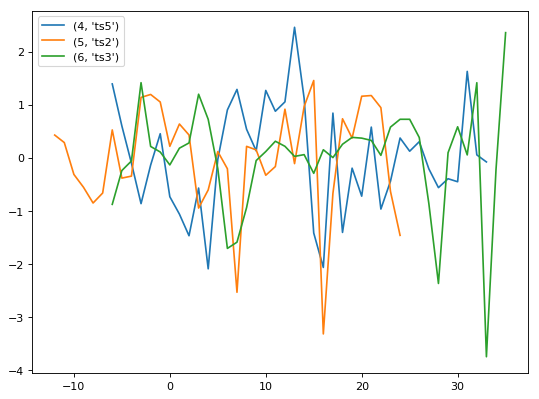

In [9]:
keys = [key for key in enumerate(my_dict)]

offsets = np.zeros(len(keys))

for i,k in enumerate(keys):
    shift,max_corr,p_value = sliding_correlation(my_dict[k[1]].Processed,my_dict[keys[max_val_locs[i]][1]].Processed)
    offsets_mask = np.ones(len(keys), dtype=bool)
    offsets_mask[i] = False
    offsets[offsets_mask] += shift[0]
    offsets_mask = np.ones(len(keys), dtype=bool)
    offsets_mask[max_val_locs[i]] = False
    offsets[offsets_mask] -= shift[1]
#     plt.plot(np.arange(len(my_dict[k[1]].Processed))+shift[0],my_dict[k[1]].Processed,label= a)
#     plt.plot(np.arange(len(my_dict[keys[max_val_locs[i]][1]].Processed))+shift[1],my_dict[keys[max_val_locs[i]][1]].Processed,label= b)


plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,k in enumerate(keys[4:7]):
    y = my_dict[k[1]].Processed
    y /= np.std(my_dict[k[1]].Processed)
    plt.plot(np.arange(len(my_dict[k[1]].Processed))+offsets[i],y,label= k)
    plt.legend()


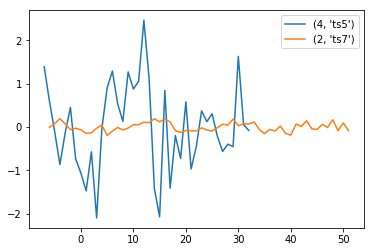

In [10]:
i=4
k=keys[i]
plt.plot(np.arange(len(my_dict[k[1]].Processed))+offsets[i],my_dict[k[1]].Processed,label= k)
i=2
k=keys[i]
plt.plot(np.arange(len(my_dict[k[1]].Processed))+offsets[i],my_dict[k[1]].Processed,label= k)
plt.legend()
plt.show()

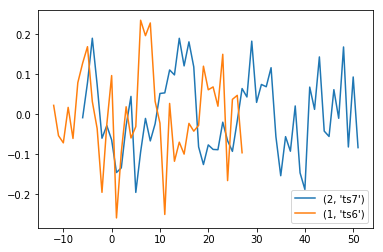

In [11]:
i=2
k=keys[i]
plt.plot(np.arange(len(my_dict[k[1]].Processed))+offsets[i],my_dict[k[1]].Processed,label= k)
i=1
k=keys[i]
plt.plot(np.arange(len(my_dict[k[1]].Processed))+offsets[i],my_dict[k[1]].Processed,label= k)
plt.legend()
plt.show()